In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hac
import seaborn as sns
from scipy.cluster.hierarchy import fcluster

import warnings
warnings.filterwarnings('ignore')

In [2]:
fn_cluster = 'list_states_clustered_by_migration_pattern.csv'
d_cluster_states = {}
for line in open(fn_cluster).readlines():
    line = line.strip().split(',')
    d_cluster_states[line[0]]=line[1:]
p_decrease = d_cluster_states['7']
p_increase = d_cluster_states['3']

In [3]:
df_linkedin = pd.read_csv("Data/temp_datalab_records_linkedin_company.csv")
df_linkedin_clean = df_linkedin.dropna(subset=['industry'])
df_linkedin_clean.loc[:,'industry']=df_linkedin_clean['industry'].apply(lambda s: s.replace('&amp;','&'))
d_company_industry = dict(df_linkedin_clean.groupby('company_name')['industry'].apply(list))

In [4]:
df_job = pd.read_csv("Data/job_listings_USA.csv", encoding = "ISO-8859-1",header=None)
df_job.columns = ['Title','Brand','Category','City','State','Date']
df_job['Date'] = pd.to_datetime(df_job['Date'], errors='coerce')
df_job['Industry'] = df_job['Brand'].apply(lambda s: d_company_industry[s][0] if s in d_company_industry else np.nan)
df_job = df_job.dropna(subset=['Industry'])

In [5]:
def get_state(row,abv_state):
    if row['State'] in abv_state:
        return abv_state[row['State']]
    elif row['City'] in abv_state:
        return abv_state[row['City']]
    else:
        return np.nan

US_code_full = 'US_state_code_to_full.csv'
abv_state = {}
for line in open(US_code_full).readlines():
    line = line.strip().split(',')
    abv_state[line[0]]=line[1]

state_abv = {v:k for k,v in abv_state.items()}
df_job.loc[:,'State_Full'] = df_job.apply(lambda row: get_state(row,abv_state), axis=1)
df_job = df_job.dropna(subset=['State_Full'])

In [6]:
df_job

,Title,Brand,Category,City,State,Date,Industry,State_Full
0,Automotive Technician Coggin Honda St. Augustine,Asbury Automotive Group,NaN,St. Augustine,FL,2018-04-12,Automotive,Florida
1,Part Time Receptionist / Nights and Weekends /...,Asbury Automotive Group,NaN,Atlanta,GA,2018-03-05,Automotive,Georgia
2,Service Technician & Used Technician McDavid P...,Asbury Automotive Group,NaN,Plano,TX,2018-04-16,Automotive,Texas
3,Part-time Receptionist / Plaza Land Rover,Asbury Automotive Group,NaN,Creve Coeur,MO,2018-04-23,Automotive,Missouri
4,Automotive Service Technician McDavid Honda Ir...,Asbury Automotive Group,NaN,Irving,TX,2018-04-30,Automotive,Texas
5,Sales Consultant / Nalley Honda,Asbury Automotive Group,NaN,Union City,GA,2018-04-25,Automotive,Georgia
6,Quick Lube Technician McDavid Honda Frisco Int...,Asbury Automotive Group,NaN,Frisco,TX,2018-04-03,Automotive,Texas
7,Sales Consultant at Crown Ford Fayetteville,Asbury Automotive Group,NaN,Fayetteville,NC,2018-04-05,Automotive,North Carolina
8,Body Shop Estimator / Toyota of Roswell,Asbury Automotive Group,NaN,Roswell,GA,2018-03-06,Automotive,Georgia
9,Sales Manager / Nalley Infiniti Atlanta,Asbury Automotive Group,NaN,Atlanta,GA,2018-04-25,Automotive,Georgia


In [7]:
df_job_2018 = df_job[df_job['Date'].dt.year==2018]
df_job_2018['Industry'].value_counts()

Retail                                 482039
Internet                               221985
Business Supplies and Equipment        218355
Banking                                 46553
Hospital & Health Care                  41459
Information Technology and Services     30799
Automotive                              23012
Investment Banking                      22530
Apparel & Fashion                       21489
Restaurants                             20898
Government Administration               18847
Renewables & Environment                18232
Electrical/Electronic Manufacturing     15560
Construction                            14525
Logistics and Supply Chain              13932
Broadcast Media                         12443
Computer Software                       12109
Pharmaceuticals                          9208
Machinery                                6772
Research                                 6470
Packaging and Containers                 5908
Biotechnology                     

In [8]:
list_industry = df_job_2018['Industry'].value_counts().index[:20]
list_state = list(set(df_job_2018['State_Full'].tolist()))
df_state_ind_2018 = pd.DataFrame(index=list_state)


for ind in list_industry:
    df_ind = df_job_2018[df_job_2018['Industry']==ind]
    d_state_ind_2018 = dict(df_ind.groupby('State_Full')['Title'].count())
    df_state_ind_2018[ind] = df_state_ind_2018.index.map(d_state_ind_2018)

df_state_ind_2018=df_state_ind_2018.fillna(0)

# normalize by total
df_state_ind_2018_norm = df_state_ind_2018.div(df_state_ind_2018.sum(axis=1), axis=0)
df_state_ind_2018_norm.dropna(inplace=True)

In [ ]:
def get_status(p,p_decrease,p_increase):
    if p in p_decrease:
        return 0
    elif p in p_increase:
        return 1
    else:
        return np.nan
    
df_state_ind_2018_norm['p_status'] = df_state_ind_2018_norm.index
df_state_ind_2018_norm['p_status'] = df_state_ind_2018_norm['p_status'].apply(lambda p: get_status(p,p_decrease,p_increase))
df_state_ind_2018_norm.dropna(subset=['p_status'],inplace=True)

In [ ]:
df_corr = pd.DataFrame(df_state_ind_2018_norm.corr()['p_status'])
df_corr.dropna(inplace=True)
df_corr = df_corr.head(len(df_corr)-1).sort_values(['p_status'],ascending =False)
df_corr.to_csv('corr_state_job.csv')
df_corr

,p_status
Logistics and Supply Chain,0.260067
Construction,0.190806
Automotive,0.188339
Hospital & Health Care,0.173034
Pharmaceuticals,0.144133
Electrical/Electronic Manufacturing,0.130980
Apparel & Fashion,0.072036
Information Technology and Services,0.054305
Banking,0.028085
Renewables & Environment,0.020396


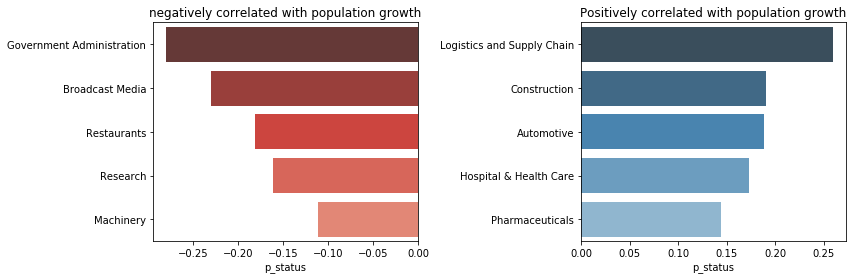

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
ax = sns.barplot(x='p_status',y=df_corr.tail(5).index, data = df_corr.tail(5),palette="Reds_d",
                 order=df_corr.tail(5).index[::-1])
ax.set_title('negatively correlated with population growth')

plt.subplot(1,2,2)
ax = sns.barplot(x='p_status',y=df_corr.head(5).index, data = df_corr.head(5),palette="Blues_d")
ax.set_title('Positively correlated with population growth')

plt.tight_layout()

In [ ]:
list_industry = set(df_job_2018['Industry'].tolist())
df_state_ind = pd.DataFrame(index=list_state)

df_job_2018 = df_job_2018[df_job_2018['Date'].dt.year==2018]
d_state_ind = df_job_2018.groupby('State_Full')['Industry']

for ind in list_industry:
    df_ind = df_job_2018[df_job_2018['Industry']==ind]
    d_state_ind = dict(df_ind.groupby('State_Full')['Title'].count())
    df_state_ind[ind] = df_state_ind.index.map(d_state_ind)
df_state_ind=df_state_ind.fillna(0)

df_state_ind_norm = df_state_ind.div(df_state_ind.sum(axis=1), axis=0)
df_state_ind_norm.dropna(inplace=True)

In [ ]:
from sklearn.cluster import KMeans

kclusters = 3
kmeans = KMeans(n_clusters=kclusters).fit(df_state_ind_norm[list_industry].values)

df_state_cluster_by_ind = pd.DataFrame({'code':[state_abv[s] for s in list_state],
                                        'state':list_state,
                                        'clusters':list(kmeans.labels_)})
df_state_cluster_by_ind

,code,state,clusters
0,DE,Delaware,1
1,MT,Montana,2
2,VA,Virginia,1
3,NC,North Carolina,0
4,MI,Michigan,2
5,PA,Pennsylvania,0
6,NH,New Hampshire,1
7,WV,West Virginia,0
8,RI,Rhode Island,1
9,KY,Kentucky,0


In [ ]:
d_state_clster = dict(zip(df_state_cluster_by_ind['state'].tolist(),df_state_cluster_by_ind['clusters'].tolist()))
df_job_2018.loc[:,'cluster'] = df_job_2018['State_Full'].apply(lambda s: d_state_clster[s] if s in d_state_clster else np.nan)
df_job_2018

,Title,Brand,Category,City,State,Date,Industry,State_Full,cluster
0,Automotive Technician Coggin Honda St. Augustine,Asbury Automotive Group,NaN,St. Augustine,FL,2018-04-12,Automotive,Florida,2
1,Part Time Receptionist / Nights and Weekends /...,Asbury Automotive Group,NaN,Atlanta,GA,2018-03-05,Automotive,Georgia,0
2,Service Technician & Used Technician McDavid P...,Asbury Automotive Group,NaN,Plano,TX,2018-04-16,Automotive,Texas,2
3,Part-time Receptionist / Plaza Land Rover,Asbury Automotive Group,NaN,Creve Coeur,MO,2018-04-23,Automotive,Missouri,2
4,Automotive Service Technician McDavid Honda Ir...,Asbury Automotive Group,NaN,Irving,TX,2018-04-30,Automotive,Texas,2
5,Sales Consultant / Nalley Honda,Asbury Automotive Group,NaN,Union City,GA,2018-04-25,Automotive,Georgia,0
6,Quick Lube Technician McDavid Honda Frisco Int...,Asbury Automotive Group,NaN,Frisco,TX,2018-04-03,Automotive,Texas,2
7,Sales Consultant at Crown Ford Fayetteville,Asbury Automotive Group,NaN,Fayetteville,NC,2018-04-05,Automotive,North Carolina,0
8,Body Shop Estimator / Toyota of Roswell,Asbury Automotive Group,NaN,Roswell,GA,2018-03-06,Automotive,Georgia,0
9,Sales Manager / Nalley Infiniti Atlanta,Asbury Automotive Group,NaN,Atlanta,GA,2018-04-25,Automotive,Georgia,0


In [ ]:
df_cluster_ind_2018 = pd.DataFrame(index=list(range(3)))

for ind in list_industry:
    df_ind = df_job_2018[df_job_2018['Industry']==ind]
    d_c_ind = dict(df_ind.groupby('cluster')['Title'].count())
    df_cluster_ind_2018[ind] = df_cluster_ind_2018.index.map(d_c_ind)

df_cluster_ind_2018=df_cluster_ind_2018.fillna(0)    
df_cluster_ind_2018_norm = df_cluster_ind_2018.div(df_cluster_ind_2018.sum(axis=1), axis=0)
df_cluster_ind_2018_norm.transpose().to_csv('industry_dis_by_cluster.csv')

In [ ]:
neg_corr = df_corr.tail(5).index
pos_corr = df_corr.head(5).index

In [ ]:
def plot_job_dist_by_corr(df_cluster_ind_2018_norm,list_corr,file_name):
    plt.figure(figsize=(12,len(list_corr)//5*3))
    for i,industry in enumerate(list_corr):
        plt.subplot(len(list_corr)//5, 5, i+1)
        ax=sns.barplot(data=[[df_cluster_ind_2018_norm.loc[0,industry]],
                             [df_cluster_ind_2018_norm.loc[1,industry]],
                             [df_cluster_ind_2018_norm.loc[2,industry]],
                            ])
        ax.set_title(industry)

    plt.tight_layout()
    plt.savefig(file_name,dpi=300)

In [ ]:
plot_job_dist_by_corr(df_cluster_ind_2018_norm,neg_corr,'job_distr_of_negative_corr.png')

In [ ]:
plot_job_dist_by_corr(df_cluster_ind_2018_norm,pos_corr,'job_distr_of_positive_corr.png')

In [ ]:
dict_cluster_statelist = dict(df_state_cluster_by_ind.groupby('clusters')['state'].apply(list))
dict_cluster_statelist